# Parte 3 del detector de Fruit-Quality

En esta última parte de nuestro detector de fruta, cambiaremos para poder detectar el fondo y de esa forma separar la fruta del fondo, para que no haya ruido que afecte al detector.

Para esto usaremos el modelo YOLOv8, el cual nos detectará la fruta que tenemos para así realizar un recorte de esta y eliminar el fondo.

Este modelo realiza es un vistazo de la imagen que tenemos, y viéndola nos detecta rápidamente que tipo de fruta es, lo que nos servirá para poder eliminar el fondo.
El modelo que tenemos implementado en el proyecto se llama YOLOv8-seg. Este primero detecta la zona dónde tenemos situada la fruta, y posteriormente realiza una segmentación, dibujando el contorno exacto píxel a píxel de la fruta. Esto nos sirve para analizar perfectamente todas las frutas, buscando sólo las imágenes que tiene ya aprendidas, e ignorando las que no son de la misma forma que la que tiene para buscar.

En primer lugar cargaremos todos los datos para comenzar a analizar.

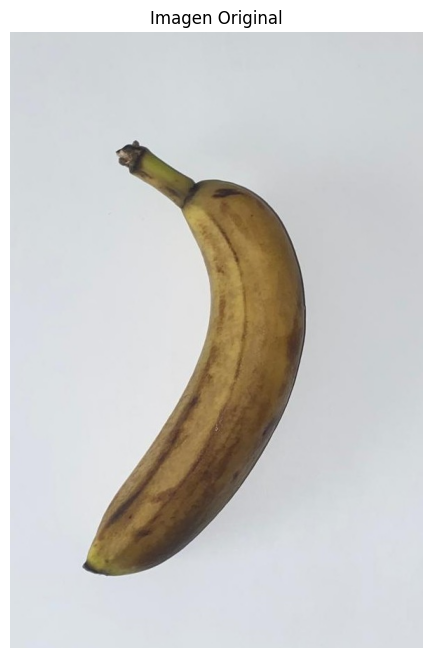

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Función auxiliar para mostrar imágenes en el Notebook
def show(img, title="", cmap=None):
    plt.figure(figsize=(8,8))
    if cmap is None:
        # Convierte de BGR (OpenCV) a RGB (Matplotlib)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Cargamos el modelo YOLOv8 preentrenado para segmentación
model = YOLO('yolov8n-seg.pt')

path = './images/'
filename = 'Platano1.jpg' 

img = cv2.imread(path + filename)

if img is None:
    print(f"Error: No se encuentra {filename} en la ruta {path}")
else:
    original = img.copy()
    show(original, f"Imagen Original")

A continuación, realizaremos la búsqueda de la fruta con YOLOv8-seg para eliminar el fondo y poder continuar usando solo la fruta.

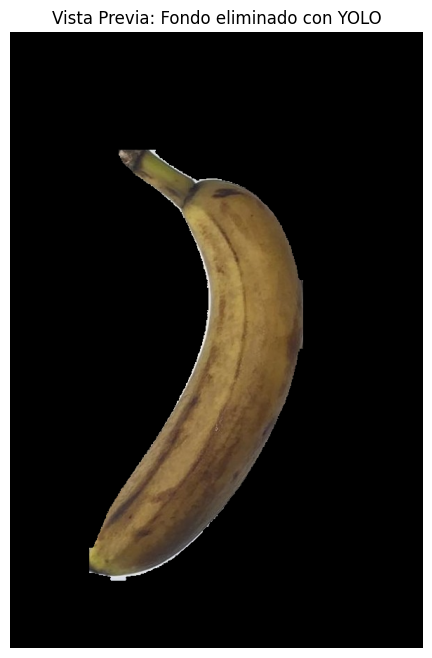

In [42]:
results = model(img, conf=0.4, verbose=False)

# Creamos una máscara vacía (todo negro) por defecto
mask_fruta = np.zeros(img.shape[:2], dtype=np.uint8)
max_area = 0

# Buscamos la fruta más grande
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    names = results[0].names
    
    for i, class_id in enumerate(classes):
        name = names[int(class_id)]
        
        # Lista de cosas que consideramos "Fruta"
        if name in ['banana', 'apple', 'pear', 'orange']:
            # Redimensionar máscara
            mask_raw = masks[i]
            mask_resized = cv2.resize(mask_raw, (img.shape[1], img.shape[0]))
            current_mask = (mask_resized * 255).astype(np.uint8)
            
            # Calculamos área
            area = cv2.countNonZero(current_mask)
            
            # LEY DEL MÁS FUERTE: Nos quedamos solo con la fruta más grande
            if area > max_area:
                max_area = area
                mask_fruta = current_mask

# Mostramos para confirmar que YOLO ha recortado bien
fruta_recortada = cv2.bitwise_and(original, original, mask=mask_fruta)
show(fruta_recortada, "Vista Previa: Fondo eliminado con YOLO")

Por último realizaremos el análisis de calidad que ya realizábamos en la parte 2 del proyecto, sin ningún cambio relevante.

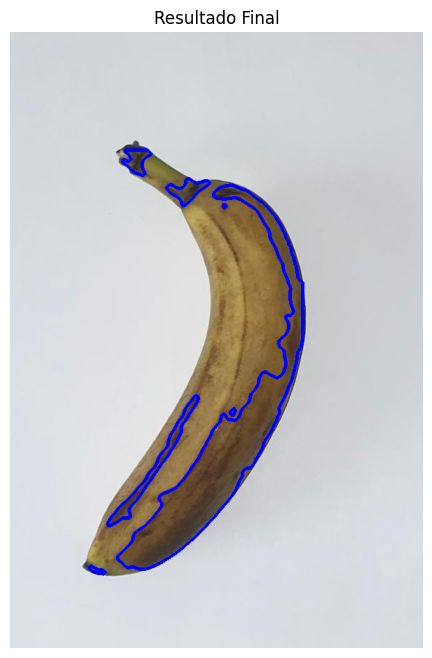

In [43]:
# Suavizado para eliminar ruido
blurred = cv2.medianBlur(img, 5)

# Detección de zonas oscuras (Histograma)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# solo calcule los colores DE LA FRUTA, no del fondo.
hist = cv2.calcHist([gray], [0], mask_fruta, [256], [0,256])

# Buscamos el pico de oscuridad en los primeros 100 valores y sumamos un margen
shadow_thresh = np.argmax(hist[:100]) + 5
_, shadow_mask = cv2.threshold(gray, shadow_thresh, 255, cv2.THRESH_BINARY)

# Limpiamos ruido en la máscara y la invertimos para que lo blanco sea lo oscuro
shadow_mask = cv2.medianBlur(shadow_mask, 9)
shadow_mask = cv2.bitwise_not(shadow_mask)

# CAMBIO PEQUEÑO 2: Recortamos la sombra para que no detecte el fondo negro como "defecto"
shadow_mask = cv2.bitwise_and(shadow_mask, shadow_mask, mask=mask_fruta)


# Detección por rango de color (HSV)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

lower_defect = np.array([0, 30, 0])
upper_defect = np.array([180, 255, 120])

color_mask = cv2.inRange(hsv, lower_defect, upper_defect)

# Aseguramos que el color defectuoso esté dentro de la fruta
color_mask = cv2.bitwise_and(color_mask, color_mask, mask=mask_fruta)


# Detección de bordes
edges = cv2.Canny(gray, 40, 120)

# Hacemos grandes los bordes para conectarlos mejor
edges = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=2)

# Quitamos los bordes del fondo
edges = cv2.bitwise_and(edges, edges, mask=mask_fruta)


# Solo aceptamos bordes que caigan dentro de la zona oscura
defect_edges = cv2.bitwise_and(edges, edges, mask=shadow_mask)

# Solo aceptamos defectos de color que caigan dentro de la zona oscura
defect_color = cv2.bitwise_and(color_mask, color_mask, mask=shadow_mask)

# Combinación
combined = cv2.bitwise_or(defect_edges, defect_color)

# Si la combinación borra todo, volvemos al color
if np.sum(combined) < 20:
    print("Aviso: Detección combinada muy baja, usando solo color.")
    combined = defect_color

# Limpieza final de la máscara combinada
combined = cv2.medianBlur(combined, 7)

# ULTIMO FILTRO DE SEGURIDAD:
combined = cv2.bitwise_and(combined, combined, mask=mask_fruta)

# Mostramos resultado final con contornos
resultado = original.copy()
contornos, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujamos en azul los contornos detectados
cv2.drawContours(resultado, contornos, -1, (255, 0, 0), thickness=3)

show(resultado, "Resultado Final")

Este código 3 y final no resulta del todo correcto, ya que como venimos comentando durante toda la práctica, el principal problema para esto es la iluminación que tiene la fruta, cuanto más iluminado esté, mejor se detecta la malformación.

Con este código podemos incluir bastantes más imágenes a nuestro código, ya que anteriormente solo podían tener fondo blanco, o de lo contrario no lo notaría, pero con este último código, podríamos insertar frutas con cualquier tipo de fondo, ya que si pertenece al modelo de YOLO, se detectará como fruta y podrá pasar a la siguiente parte del algoritmo.